In [764]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import geopandas as gpd
import jenkspy
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
from scipy.stats import pearsonr
import scipy
import prophet
import warnings
warnings.filterwarnings("ignore")
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.optimize import curve_fit
import matplotlib.colors as colors
import mapclassify
from libpysal.weights.contiguity import Queen
from libpysal import examples
import geopandas as gpd
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from scipy.interpolate import UnivariateSpline

In [765]:
font_path = '/Users/carmen/anaconda3/pkgs/r-rmarkdown-2.27-r43hc72bb7e_1/lib/R/library/rmarkdown/rmd/h/bootstrap/css/fonts/RobotoBold.ttf'
font = FontProperties(fname=font_path)

In [921]:
# data = 'mp'
data = 'fb'

In [922]:
if data == 'mp':
    shap = pd.read_csv("/Users/carmen/Documents/github/de-bias/DEBIAS_MX/Final_Results_BlockedCV/Final_Results_BlockedCV_GS5184_P05_Knn/03.Shap Dependence/Shap_Dependence_CV_Avg.csv")
else:
    shap = pd.read_csv("/Users/carmen/Documents/github/de-bias/DEBIAS_MX/Final_Results_BlockedCV/Final_Results_BlockedCV_GS5184_TTS_Knn/03.Shap Dependence/Shap_Dependence_CV_Avg.csv")
    

In [923]:
areas = gpd.read_file("/Users/carmen/Documents/github/de-bias/DEBIAS_MX/Final_Results_BlockedCV/Final_Results_BlockedCV_GS5184_P05_Knn/Inputs/Geographical_areas.shp")
areas["Area_code"] = areas["Area_code"].astype(int)

states = gpd.read_file("/Users/carmen/Documents/github/de-bias/DEBIAS_MX/SHP/States SHP/gadm41_MEX_1.shx").to_crs(areas.crs)

In [997]:
features = np.unique(shap['Feature'])
feature = features[5]
feature

'Total_houses'

In [998]:
shap_feature = shap[shap['Feature']==feature].reset_index(drop=True)

shap_feature_group = shap_feature.groupby("Area_code").mean()

shap_feature_group = shap_feature_group.reset_index(drop=False)
shap_feature_group = shap_feature_group.drop(['Fold_ID'], axis=1)
shap_feature_group = areas.merge(
    shap_feature_group,
    on="Area_code",
    how="left"
)

gdf_shap = gpd.GeoDataFrame(shap_feature_group, geometry="geometry")

In [999]:
def scale_zero_centered(series):
    x = series.values

    # find dynamic min negative and max positive
    min_neg = x[x < 0].min() if np.any(x < 0) else None
    max_pos = x[x > 0].max() if np.any(x > 0) else None

    out = np.zeros_like(x, dtype=float)

    # scale negatives
    if min_neg is not None:
        neg = x < 0
        out[neg] = x[neg] / abs(min_neg)

    # scale positives
    if max_pos is not None:
        pos = x > 0
        out[pos] = x[pos] / max_pos

    return out

In [1000]:
gdf_shap["Feature_Value_scaled"] = scale_zero_centered(gdf_shap["Feature_Value"])
gdf_shap["SHAP_Value_scaled"]    = scale_zero_centered(gdf_shap["SHAP_Value"])

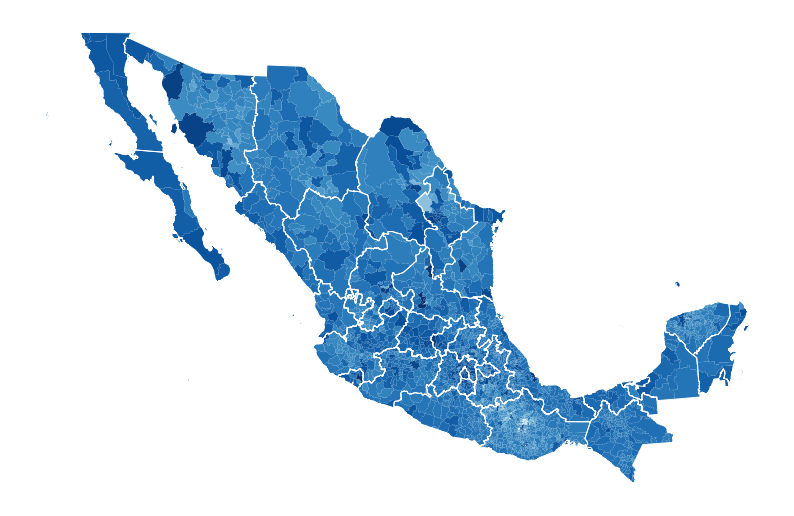

In [1001]:
fig, ax = plt.subplots(figsize=(10, 7.5))

# gdf_shap.plot(column="Standardized_Shape_Value", ax=ax)



gdf_shap["SHAP_Value"] = gdf_shap["SHAP_Value"].interpolate(method="linear", limit_direction="both")

if data == 'mp':
    cmap_color = 'Reds'
else:
    cmap_color = 'Blues'
gdf_shap.plot(
    column="SHAP_Value",
    cmap=cmap_color,   # or "bwr", or "seismic"
    scheme=None,
    legend=False,
    lw=0,
    ax=ax
)

states.plot(ax=ax, facecolor="None", edgecolor='w', lw=0.7)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

plt.savefig('/Users/carmen/Documents/github/de-bias/DEBIAS_MX/manuscript/figures/plots/SHAP-map/SHAP_map_' + feature + '_' + data + '.png', bbox_inches='tight')

plt.show()

In [1002]:
y = gdf_shap['SHAP_Value'].values
w = Queen.from_dataframe(gdf_shap)
w.transform = 'r'
moran_loc = Moran_Local(y, w)

gdf_shap['moran_loc_mp'] = moran_loc.Is
gdf_shap['q_mp'] = moran_loc.q
gdf_shap['p_sim_mp'] = moran_loc.p_sim

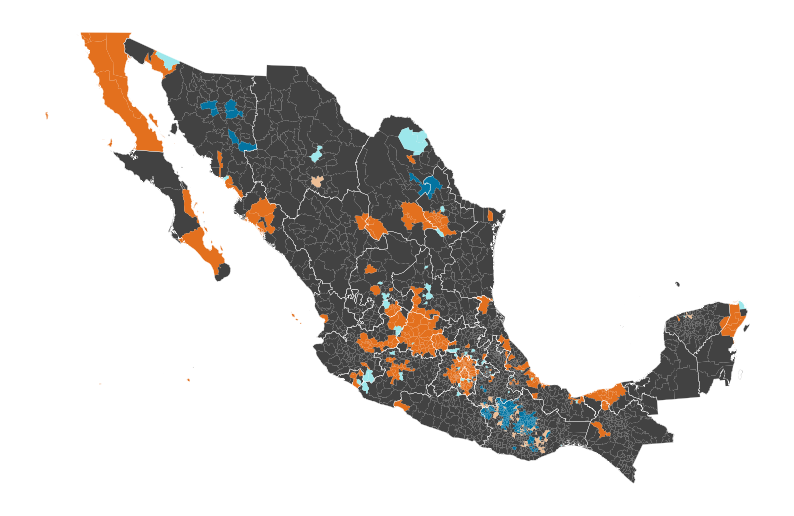

In [1003]:
fig, ax = plt.subplots(figsize=(10, 7.5))

# gdf_shap.plot(column="Standardized_Shape_Value", ax=ax)

color_dict = {
    1: '#e3701e',   
    2: '#9de7eb',   
    3: '#0374a1',   
    4: '#edbe95',   
}


# Map colors to each row based on q
gdf_shap['colors_mp'] = gdf_shap['q_mp'].map(color_dict)
gdf_shap['colors_mp'] = np.where(gdf_shap['p_sim_mp'] > 0.05, '#424242', gdf_shap['colors_mp'])

gdf_shap.plot(gdf_shap['colors_mp'], color=gdf_shap['colors_mp'], lw=0, ax=ax)

states.plot(ax=ax, facecolor="None", edgecolor='w', lw=0.2)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

plt.savefig('/Users/carmen/Documents/github/de-bias/DEBIAS_MX/manuscript/figures/plots/SHAP-map-lisa/SHAP_map_lisa_' + feature + '_' + data + '.png', bbox_inches='tight')


plt.show()

In [1004]:
y = gdf_shap['Feature_Value_scaled'].values
w = Queen.from_dataframe(gdf_shap)
w.transform = 'r'
moran_loc = Moran_Local(y, w)

gdf_shap['moran_loc_feature_mp'] = moran_loc.Is
gdf_shap['q_feature_mp'] = moran_loc.q
gdf_shap['p_feature_sim_mp'] = moran_loc.p_sim

In [1005]:
np.unique(gdf_shap['q_feature_mp'])

array([1, 2, 3, 4])

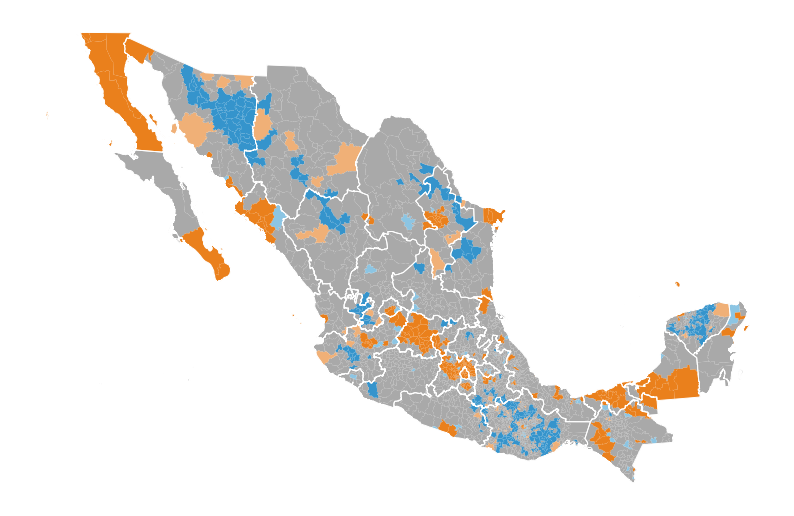

In [1006]:
fig, ax = plt.subplots(figsize=(10, 7.5))

# gdf_shap.plot(column="Standardized_Shape_Value", ax=ax)

color_dict = {
    1: '#ea801c',   
    2: '#8cc5e3',   
    3: '#3594cc',   
    4: '#f0b077',   
}


# Map colors to each row based on q
gdf_shap['colors_mp'] = gdf_shap['q_feature_mp'].map(color_dict)
gdf_shap['colors_mp'] = np.where(gdf_shap['p_feature_sim_mp'] > 0.05, 'darkgray', gdf_shap['colors_mp'])

gdf_shap.plot(gdf_shap['colors_mp'], color=gdf_shap['colors_mp'], lw=0, ax=ax)

states.plot(ax=ax, facecolor="None", edgecolor='w', lw=0.7)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

plt.savefig('/Users/carmen/Documents/github/de-bias/DEBIAS_MX/manuscript/figures/plots/SHAP-map-lisa-feature/SHAP_map_lisa_feature_' + feature + '_' + data + '.png', bbox_inches='tight')


plt.show()

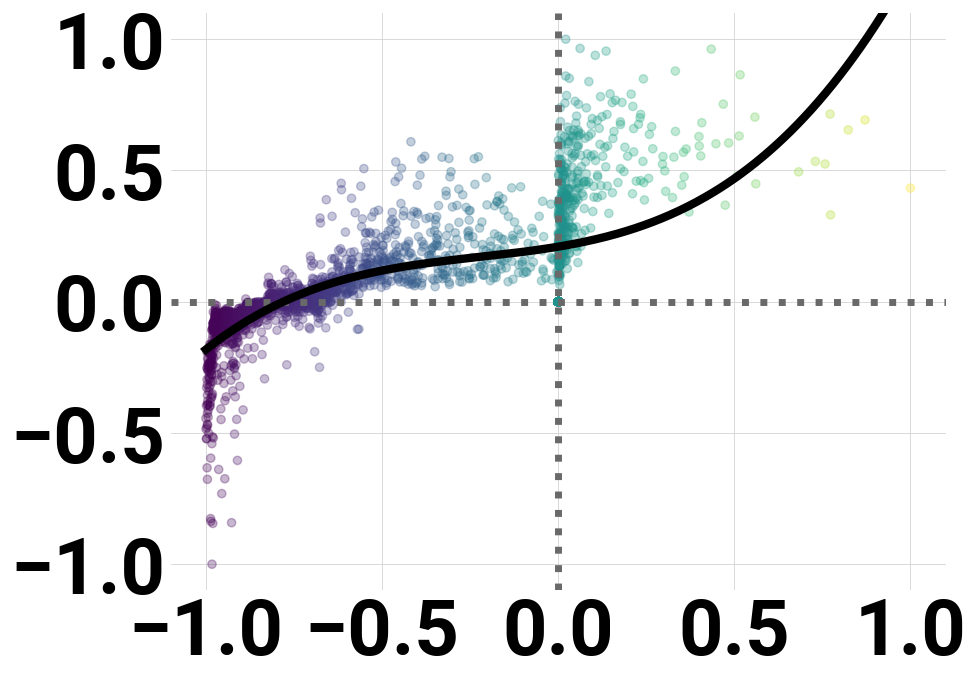

In [1007]:

fig, ax = plt.subplots(figsize=(10, 7.5))


gdf_shap["Feature_Value_scaled"] = gdf_shap["Feature_Value_scaled"].interpolate(method="linear", limit_direction="both")

if data == 'mp':
    cmap_color = 'inferno'
else:
    cmap_color = 'viridis'

ax.scatter(gdf_shap['Feature_Value_scaled'], gdf_shap['SHAP_Value_scaled'], alpha=0.3,
          c=gdf_shap['Feature_Value_scaled'], 
          cmap=cmap_color)

x = gdf_shap["Feature_Value_scaled"].values
y = gdf_shap["SHAP_Value_scaled"].values
order = np.argsort(x)
x = x[order]
y = y[order]
spline = UnivariateSpline(x, y, s= len(x))   
x_smooth = np.linspace(x.min(), x.max(), 400)
y_smooth = spline(x_smooth)

ax.plot(x_smooth, y_smooth, '-', label='cubic spline', color='k', lw=6)

ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font)
    
tick_vals = [-1, -0.5, 0, 0.5, 1]
ax.set_xticks(tick_vals)
ax.set_yticks(tick_vals)

for x in ax.get_xticks():
    ax.axvline(x, color='lightgray', linewidth=0.6, linestyle='-', zorder=0)
for y in ax.get_yticks():
    ax.axhline(y, color='lightgray', linewidth=0.6, linestyle='-', zorder=0)
    
ax.axvline(0, color='dimgray', linewidth=5, linestyle=':', zorder=1)
ax.axhline(0, color='dimgray', linewidth=5, linestyle=':', zorder=1)
    
for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='both', which='both', width=0, length=0, labelsize=56, pad=4)
ax.tick_params(axis='both', which='both', width=0, length=0, labelsize=56, pad=4)

plt.savefig('/Users/carmen/Documents/github/de-bias/DEBIAS_MX/manuscript/figures/plots/SHAP-dependence/SHAP_dependence_' + feature + '_' + data + '.png', bbox_inches='tight')

plt.show()